<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/Pair-Trading/Pair_Trading_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def generate_cointegrated_ts():
  p_value = 1
  while p_value > 0.3:
    # Generate correlated time series.
    # 1. Simulate 500 correlated random variables by Cholesky Decomposition.
    corr = np.array([[1.0, 0.9],
                    [0.9, 1.0]])
    L = scipy.linalg.cholesky(corr)
    rnd = np.random.normal(0, 1, size=(500, 2))
    out = rnd @ L

    # 2. Simulate GBM returns and prices.
    dt = 1/252
    base1 = 110; mu1 = 0.01; sigma1 = 0.05
    base2 = 80;  mu2 = 0.03; sigma2 = 0.05
    ret1  = np.exp((mu1 - 0.5 * (sigma1 ** 2) ) * dt + sigma1 * out[:, 0] * np.sqrt(dt))
    ret2  = np.exp((mu2 - 0.5 * (sigma2 ** 2) ) * dt + sigma2 * out[:, 1] * np.sqrt(dt))

    price1 = base1 * np.cumprod(ret1)
    price2 = base2 * np.cumprod(ret2)

    # 3. Calculate the return correlation and the p-value for cointegration testing.
    corr_ret , _   = scipy.stats.pearsonr(ret1, ret2)
    corr_price , _ = scipy.stats.pearsonr(price1, price2)
    _, p_value, _  = coint(price1, price2)
  data = {'Time': [i for i in range(500)], 
        'X': ret1,
        'Y': ret2,
        'Spread': ret1-ret2}
  
# Convert the dictionary into DataFrame 
  data = pd.DataFrame(data) 
  return data


In [ ]:
data = generate_cointegrated_ts()

In [ ]:
# import pandas as pd
# data = {'Time': [i for i in range(500)], 
#         'X': ret1,
#         'Y': ret2,
#         'Spread': ret1-ret2}
  
# # Convert the dictionary into DataFrame 
# data = pd.DataFrame(data) 
print(data)

     Time         X         Y    Spread
0       0  1.005607  1.005680 -0.000074
1       1  1.003122  1.005983 -0.002861
2       2  1.005935  1.004075  0.001860
3       3  1.003032  1.002603  0.000429
4       4  0.999710  1.000385 -0.000676
..    ...       ...       ...       ...
495   495  1.001425  1.001611 -0.000186
496   496  0.997520  0.998180 -0.000660
497   497  1.000946  1.001502 -0.000556
498   498  0.999410  0.999681 -0.000271
499   499  0.996426  0.996376  0.000051

[500 rows x 4 columns]


In [ ]:
return_data = data.pct_change()
return_data.dropna()
print(return_data)

         Time         X         Y     Spread
0         NaN       NaN       NaN        NaN
1         inf -0.002470  0.000301  37.899511
2    1.000000  0.002803 -0.001897  -1.650154
3    0.500000 -0.002886 -0.001466  -0.769395
4    0.333333 -0.003312 -0.002212  -2.575290
..        ...       ...       ...        ...
495  0.002024 -0.002970 -0.002013  -1.239895
496  0.002020 -0.003899 -0.003425   2.546216
497  0.002016  0.003434  0.003328  -0.158256
498  0.002012 -0.001534 -0.001818  -0.512342
499  0.002008 -0.002985 -0.003306  -1.186873

[500 rows x 4 columns]


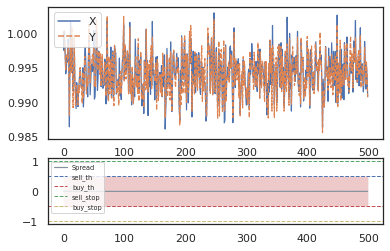

In [ ]:
def plot_spread(df, ticker1, ticker2, idx, th, stop):
  
    px1 = df[ticker1].iloc[idx] / df[ticker1].iloc[idx[0]]
    px2 = df[ticker2].iloc[idx] / df[ticker2].iloc[idx[0]]

    sns.set(style='white')
    
    # Set plotting figure
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the 1st subplot
    sns.lineplot(data=[px1, px2], linewidth=1.2, ax=ax[0])
    ax[0].legend(loc='upper left')
    
    # Calculate the spread and other thresholds
    spread = df[ticker1].iloc[idx] - df[ticker2].iloc[idx]
    mean_spread = spread.mean()
    sell_th     = mean_spread + th
    buy_th      = mean_spread - th
    sell_stop   = mean_spread + stop
    buy_stop    = mean_spread - stop
    
    # Plot the 2nd subplot
    sns.lineplot(data=spread, color='#85929E', ax=ax[1], linewidth=1.2)
    ax[1].axhline(sell_th,   color='b', ls='--', linewidth=1, label='sell_th')
    ax[1].axhline(buy_th,    color='r', ls='--', linewidth=1, label='buy_th')
    ax[1].axhline(sell_stop, color='g', ls='--', linewidth=1, label='sell_stop')
    ax[1].axhline(buy_stop,  color='y', ls='--', linewidth=1, label='buy_stop')
    ax[1].fill_between(idx, sell_th, buy_th, facecolors='r', alpha=0.3)
    ax[1].legend(loc='upper left', labels=['Spread', 'sell_th', 'buy_th', 'sell_stop', 'buy_stop'], prop={'size':6.5})
    
idx = range(0, 500)
plot_spread(data, 'X', 'Y', idx, 0.5, 1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



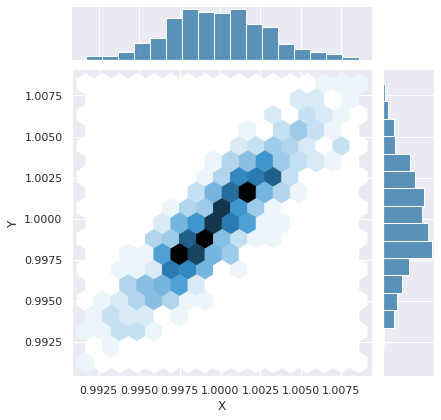

In [ ]:

sns.set(style='darkgrid')
sns.jointplot(data['X'], data['Y'],  kind='hex', color='#2874A6')

In [ ]:
x = data['X']
#print(x)
y = data['Y']
#print(y)
_, p_value, _ = coint(x, y)
print("The p-value for X-Y pair is: ", p_value)

The p-value for X-Y pair is:  0.0


#Modified State Space

Now the $step$ function will take action in tuple, i.e. 

$a^{(t)} = (a_x^{(t)}, a_y^{(t)})$ 

$s.t. \mid a_x^{(t)} \mid = \mid a_y^{(t)} \mid,     sign(a_x^{(t)}) \neq  sign(a_y^{(t)})$

$(a_x^{(t)}, a_y^{(t)})\in (k,-k),  k \in \mathbf{Z}, k\in[-9,9]$

In word, I have the following constraints: 


1.   **Self-Hedging**: using the proceed from shorting one asset to fund the purchase of the other. In this case, if one asset price rises, the other is likely to rise as well (co-integration), which means the short position won't be fully exposed. 
2.   **Trade on Spread**: since the above self-hedging action space, the model will be less sensitive to the price change themselves, but be more sensitive to the spread. 

https://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=2447&context=gradreports This literature suggests to use the spread as the reward signal directly, so that an ordinary discrete action space will eventually converge. But from my experiment, it barely converges. 



In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=10):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = [[],[]]   #First list is inventory of X, second is Y
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: Hold
        # act = 1: Buy X and Sell Y
        # act = 2: Sell X and Buy Y
        # act = 3: Buy 2X and Sell 2Y
        #...... 
        # Generally, for act > 0: if act is odd, we buy X and sell Y. The amt sold is (act+1) / 2
        # Here act can go from 0 to 19. meaning up to 10 units 
        
        if act == 0:
            pass
        elif act == 19:  #Executing position. 
            profits = 0
            for p in self.positions[0]:
                if p > 0:  #This is a long unit
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                if p < 0:  #This is a long unit
                    profits += (-self.data.iloc[self.t, :]['X'] - p)    
            for p in self.positions[1]:
                if p > 0:  #This is a long unit
                    profits += (self.data.iloc[self.t, :]['Y'] - p)
                if p < 0:  #This is a long unit
                    profits += (-self.data.iloc[self.t, :]['Y'] - p)
            reward += profits
            self.profits += profits
            self.positions = [[],[]]
        elif act % 2 == 1:    #buy X and sell Y
            for i in range(int(np.ceil((act+1)/2))):
                self.positions[0].append(self.data.iloc[self.t, :]['X'])      #buy x
                self.positions[1].append(-self.data.iloc[self.t, :]['Y'])     #short sell y
        elif act % 2 == 0: # sell X buy Y
            for i in range(int(np.ceil((act+1)/2))):
                self.positions[0].append(self.data.iloc[self.t, :]['X'])      #buy x
                self.positions[1].append(-self.data.iloc[self.t, :]['Y'])     #short sell y
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions[0]:
            if p > 0:  #This is a long unit
                    self.position_value  += (self.data.iloc[self.t, :]['X'] - p)
            if p < 0:  #This is a long unit
                    self.position_value  += (-self.data.iloc[self.t, :]['X'] - p)    
        for p in self.positions[1]:
            if p > 0:  #This is a long unit
                self.position_value  += (self.data.iloc[self.t, :]['Y'] - p)
            if p < 0:  #This is a long unit
                self.position_value  += (-self.data.iloc[self.t, :]['Y'] - p)
        self.history.pop(0)
        if self.positions[0][0] < 0:  #Shorting X
            self.history.append(-(self.data.iloc[self.t, :]['X'] - self.data.iloc[self.t-1, :]['X']) + (self.data.iloc[self.t, :]['Y'] - self.data.iloc[self.t-1, :]['Y']))
        else: 
            self.history.append(-(self.data.iloc[self.t, :]['Y'] - self.data.iloc[self.t-1, :]['Y']) + (self.data.iloc[self.t, :]['X'] - self.data.iloc[self.t-1, :]['X']))
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done, self.positions, self.data.iloc[self.t, :]['Spread'] # obs, reward, done

In [ ]:

class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [ ]:
hidden_size=50
input_size=11
output_size=20
USE_CUDA = False
LR = 0.001

In [ ]:
Q = Q_Network(input_size, hidden_size, output_size)
Q_ast = copy.deepcopy(Q)
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)
#epoch_num = 20
memory_size = 20000
batch_size = 200
gamma = 0.99

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.01
start_reduce_epsilon = 200
train_freq = 20
update_q_freq = 20
gamma = 0.999
show_log_freq = 100
num_epoch = 200

In [ ]:
master_reward = []
for epoch in range(num_epoch):
    epoch_data = generate_cointegrated_ts()
    print("Percentage done: ", epoch/num_epoch)
    #epoch_data = pd.DataFrame(epoch_data) 
    env = Environment1(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(20)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()
        # if step == step_max - 1:
        #   pact = 2
        # act
        obs, reward, done,shit1, shit2  = env.step(pact)
        # if done is True:
        #     print("action is: ", actual_action, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        #memory.append((pobs, actual_action, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

In [ ]:
test_dataset = []
for i in range(1000):
    corr = np.array([[1.0, 0.9],
                    [0.9, 1.0]])
    L = scipy.linalg.cholesky(corr)
    rnd = np.random.normal(0, 1, size=(500, 2))
    out = rnd @ L
    #print("Percent done: ", i/10000)
    # 2. Simulate GBM returns and prices.
    dt = 1/252
    base1 = 110; mu1 = 0.01; sigma1 = 0.05
    base2 = 80;  mu2 = 0.03; sigma2 = 0.05
    ret1  = np.exp((mu1 - 0.5 * (sigma1 ** 2) ) * dt + sigma1 * out[:, 0] * np.sqrt(dt))
    ret2  = np.exp((mu2 - 0.5 * (sigma2 ** 2) ) * dt + sigma2 * out[:, 1] * np.sqrt(dt))

    price1 = base1 * np.cumprod(ret1)
    price2 = base2 * np.cumprod(ret2)

    # 3. Calculate the return correlation and the p-value for cointegration testing.
    corr_ret , _   = scipy.stats.pearsonr(ret1, ret2)
    corr_price , _ = scipy.stats.pearsonr(price1, price2)
    _, p_value, _  = coint(price1, price2)
    if p_value <= 0.3: 
        data = {'Time': [i for i in range(500)], 
        'X': ret1,
        'Y': ret2,
        'Spread': ret1 - ret2}
        data = pd.DataFrame(data) 
        test_dataset.append(data)   #Use some co-integrated dataset. 

In [ ]:
print(len(test_dataset)-1)

205


In [ ]:
actions = []
test_profits = []
samplepath_number = []
all_inventory = [[],[]]
all_spread = []
count=0
for dataset in test_dataset:
  epoch_action = []
  inventory_X = []
  inventory_Y = []
  spread = []
  test_env = Environment1(dataset)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", count*100/len(test_dataset))
  count+=1
  for i in range(len(test_env.data)-1):
      #inventory.append(0)
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      # if pact.numpy() == 1:
      #   if i > 0:
      #     inventory[i] = inventory[i-1]+1

      obs, reward, done, epoch_inventory, epoch_spread = test_env.step(pact.numpy())
      inventory_X.append(len(epoch_inventory[0]))
      inventory_Y.append(len(epoch_inventory[1]))
      epoch_action.append(pact.numpy())
      test_rewards.append(reward)
      spread.append(epoch_spread)
      pobs = obs
  epoch_action[len(test_env.data)-2] = 19
  actions.append(epoch_action)
  all_inventory[0].append(inventory_X)  
  all_inventory[1].append(inventory_Y)    
  all_spread.append(spread)  
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt


Expected Profit:  1.8922223684524746
E[X|X>= 95 percentile] 2.475283990622264
E[X|X<= 5 percentile] 1.2573850568825986


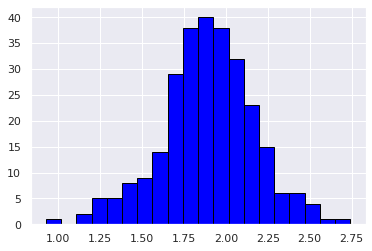

In [ ]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)
average_profit = np.mean(test_profits)
CTE_upper = np.mean([i for i in test_profits if i >= np.quantile(test_profits, 0.95)])
CTE_lower = np.mean([i for i in test_profits if i <= np.quantile(test_profits, 0.05)])
print("Expected Profit: ", average_profit)
print("E[X|X>= 95 percentile]",CTE_upper)
print("E[X|X<= 5 percentile]",CTE_lower)

In [ ]:
updated_all_inventory = all_inventory
for j in range(len(all_inventory)):
  for i in range(len(all_inventory[j])):
    updated_all_inventory[j][i].insert(0,0)
    #del updated_all_inventory[i][0]
    del updated_all_inventory[j][i][len(all_inventory[0])-1]
    #updated_all_inventory[i][len(all_inventory[0])-1] = 0
#print(updated_all_inventory[2])
#print(len(updated_all_inventory[2]))

In [ ]:
print(len(updated_all_inventory))
print(len(all_inventory))
print(len(actions))
print(len(updated_all_inventory[0]))

2
2
277
277


In [ ]:
inventory_spot_X = []
inventory_spot_Y = []
price_spot_X = []
price_spot_Y = []
action_spot = []
spread_spot = []
for i in range(len(actions)):
  for j in range(0,499):
    price_spot_X.append(test_dataset[i]['X'][j])
    price_spot_Y.append(test_dataset[i]['Y'][j])
    inventory_spot_X.append(updated_all_inventory[0][i][j])
    inventory_spot_Y.append(updated_all_inventory[1][i][j])
    action_spot.append(actions[i][j])
    spread_spot.append(all_spread[i][j])
X_price_quartile = []
print("Loaded")
X_first_quantile = np.quantile(price_spot_X,0.2)
X_second_quantile = np.quantile(price_spot_X,0.5)
X_third_quantile = np.quantile(price_spot_X,0.8)
print("Done")
for i in range(len(price_spot_X)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot_X[i] <= X_first_quantile:
    X_price_quartile.append(1)
  elif X_first_quantile < price_spot_X[i] <= X_second_quantile:
    X_price_quartile.append(2)
  elif X_second_quantile < price_spot_X[i] <= X_third_quantile:
    X_price_quartile.append(3)
  elif X_third_quantile < price_spot_X[i]:
    X_price_quartile.append(4)

Y_price_quartile = []
print("Loaded")
Y_first_quantile = np.quantile(price_spot_Y,0.2)
Y_second_quantile = np.quantile(price_spot_Y,0.5)
Y_third_quantile = np.quantile(price_spot_Y,0.8)
print("Done")
for i in range(len(price_spot_Y)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot_Y[i] <= Y_first_quantile:
    Y_price_quartile.append(1)
  elif Y_first_quantile < price_spot_Y[i] <= Y_second_quantile:
    Y_price_quartile.append(2)
  elif Y_second_quantile < price_spot_Y[i] <= Y_third_quantile:
    Y_price_quartile.append(3)
  elif Y_third_quantile < price_spot_Y[i]:
    Y_price_quartile.append(4)

spread_quartile = []
print("Loaded")
spread_first_quantile = np.quantile(spread_spot,0.2)
spread_second_quantile = np.quantile(spread_spot,0.5)
spread_third_quantile = np.quantile(spread_spot,0.8)
print("Done")
for i in range(len(spread_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if spread_spot[i] <= spread_first_quantile:
    spread_quartile.append(1)
  elif spread_first_quantile < spread_spot[i] <= spread_second_quantile:
    spread_quartile.append(2)
  elif spread_second_quantile < spread_spot[i] <= spread_third_quantile:
    spread_quartile.append(3)
  elif spread_third_quantile < spread_spot[i]:
    spread_quartile.append(4)

data = np.transpose([X_price_quartile, Y_price_quartile, inventory_spot_X,inventory_spot_Y,action_spot,spread_quartile]) 
raw_data =  np.transpose([price_spot_X, price_spot_Y, inventory_spot_X,inventory_spot_Y,action_spot,spread_spot]) 
df = pd.DataFrame(data, columns = ['priceX','priceY', 'inventoryX','inventoryY','action','spread'])
df_raw = pd.DataFrame(raw_data, columns = ['priceX','priceY', 'inventoryX','inventoryY','action','spread'])

Loaded
Done
Loaded
Done
Loaded
Done


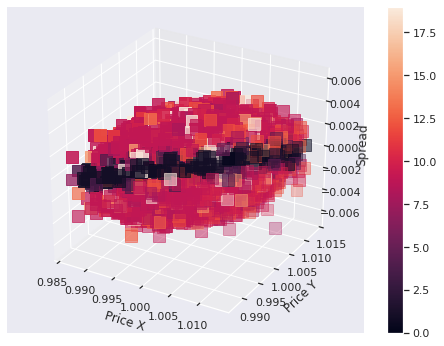

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
from pylab import *

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


#colmap = cm.ScalarMappable(cmap=cm.Greens_r)
colmap = cm.ScalarMappable()
colmap.set_array(df_raw[['action']])

#ax.scatter(df_raw[['priceX']], df_raw[['priceY']], df_raw[['spread']], marker='s',s = 140, c=df_raw[['action']],cmap='Greens_r');
ax.scatter(df_raw[['priceX']], df_raw[['priceY']], df_raw[['spread']], marker='s',s = 140, c=df_raw[['action']]);
cb = fig.colorbar(colmap)

ax.set_xlabel('Price X');
ax.set_ylabel('Price Y');
ax.set_zlabel('Spread');
plt.show()

# ax.view_init(azim = 180+40,elev = 22) 

In [ ]:
table = pd.pivot_table(df_raw, values='action', index=['priceX'], columns = ['priceY'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")

#Memory Crash... 